### Simple 1D example of `DDPM`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from util import (
    print_model_parameters,
    gp_sampler,
    get_torch_size_string,
    plot_1xN_torch_traj_tensor,
    periodic_step,
)
from dataset import get_1d_training_data
from diffusion import (
    get_ddpm_constants,
    plot_ddpm_constants,
    DiffusionUNet,
    forward_sample,
    eval_ddpm_1d,
)
from dataset import mnist
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.0.1].


### Initialize

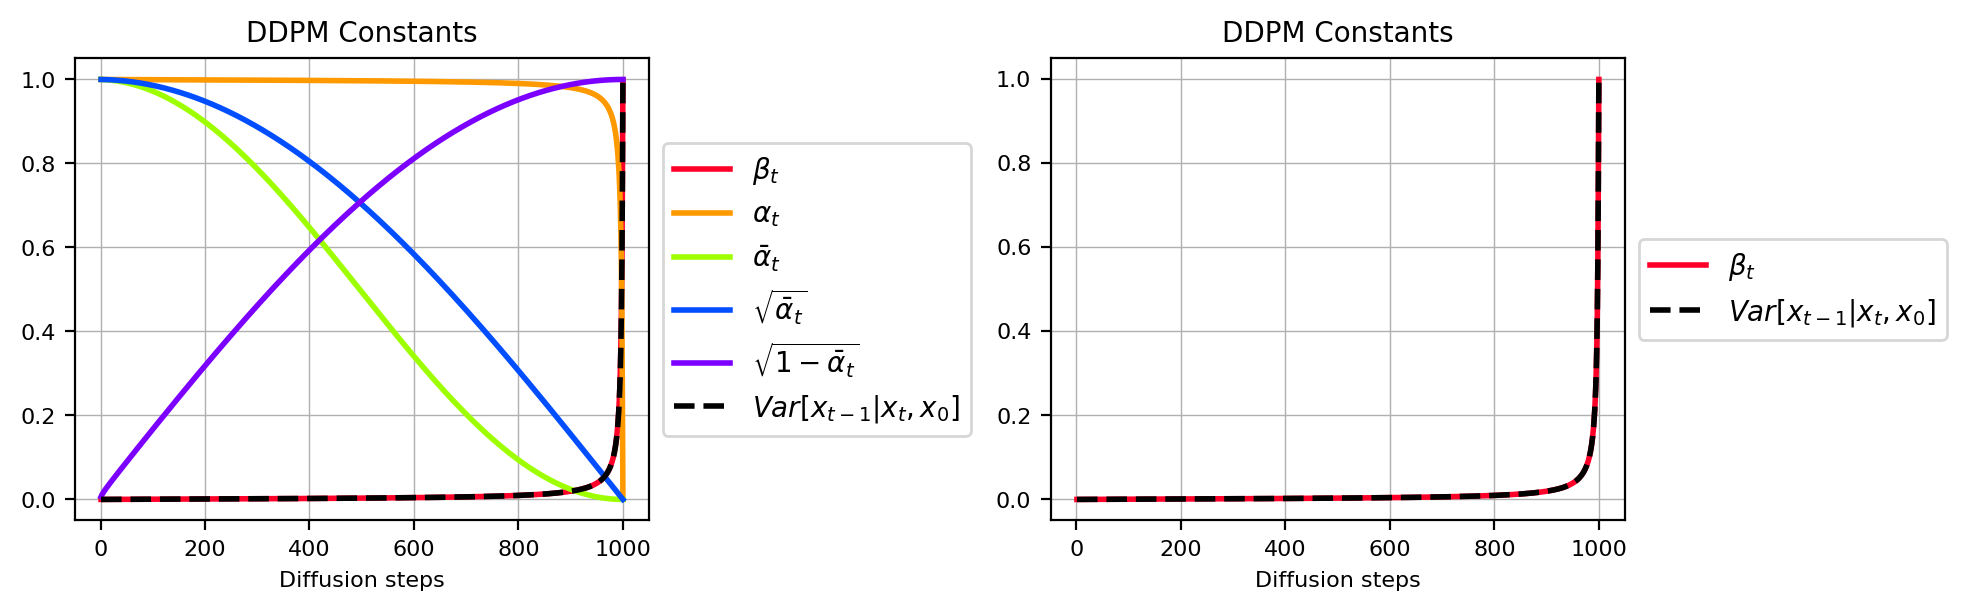

In [2]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
# for k_idx,key in enumerate(dc.keys()): print ("[%2d] key:[%s]"%(k_idx,key))
plot_ddpm_constants(dc)

In [3]:
# Instantiate U-net
device = 'mps' # mps, cpu
model = DiffusionUNet(
    name             = 'unet',
    dims             = 1,
    n_in_channels    = 1,
    n_model_channels = 32,
    n_emb_dim        = 128,
    n_enc_blocks     = 3, # number of encoder blocks
    n_dec_blocks     = 3, # number of decoder blocks
    n_groups         = 16, # group norm paramter
    n_heads          = 4, # number of heads in QKV attention
    kernel_size      = 15, # kernel size (3)
    padding          = 7, # padding size (1)
    use_resblock     = True,
    use_attention    = True,
    skip_connection  = True, # additional skip connection
    device           = device,
) # input:[B x C x L] => output:[B x C x L]
x = th.randn(1,model.n_in_channels,100).to(device) # [B x C x L]
timesteps = th.zeros(1).to(th.int64).to(device) # [B]
out,intermediate_output_dict = model(x,timesteps)
# Print intermediate layers
for k_idx,key in enumerate(intermediate_output_dict.keys()):
    z = intermediate_output_dict[key]
    print ("[%2d] key:[%14s] shape:[%12s]"%(k_idx,key,get_torch_size_string(z)))

[ 0] key:[             x] shape:[     1x1x100]
[ 1] key:[      x_lifted] shape:[    1x32x100]
[ 2] key:[  h_enc_res_00] shape:[    1x32x100]
[ 3] key:[  h_enc_att_01] shape:[    1x32x100]
[ 4] key:[  h_enc_res_02] shape:[    1x32x100]
[ 5] key:[  h_enc_att_03] shape:[    1x32x100]
[ 6] key:[  h_enc_res_04] shape:[    1x32x100]
[ 7] key:[  h_enc_att_05] shape:[    1x32x100]
[ 8] key:[   h_enc_stack] shape:[    1x96x100]
[ 9] key:[  h_dec_res_00] shape:[    1x32x100]
[10] key:[  h_dec_att_01] shape:[    1x32x100]
[11] key:[  h_dec_res_02] shape:[    1x32x100]
[12] key:[  h_dec_att_03] shape:[    1x32x100]
[13] key:[  h_dec_res_04] shape:[    1x32x100]
[14] key:[  h_dec_att_05] shape:[    1x32x100]
[15] key:[           out] shape:[     1x1x100]


In [4]:
# Print the number of model parameters
print_model_parameters(model)

[ 0] parameter:[        time_embed.0.weight] shape:[     128x128] numel:[     16384]
[ 1] parameter:[          time_embed.0.bias] shape:[         128] numel:[       128]
[ 2] parameter:[        time_embed.2.weight] shape:[     128x128] numel:[     16384]
[ 3] parameter:[          time_embed.2.bias] shape:[         128] numel:[       128]
[ 4] parameter:[                lift.weight] shape:[      32x1x1] numel:[        32]
[ 5] parameter:[                  lift.bias] shape:[          32] numel:[        32]
[ 6] parameter:[                proj.weight] shape:[      1x32x1] numel:[        32]
[ 7] parameter:[                  proj.bias] shape:[           1] numel:[         1]
[ 8] parameter:[enc_net.enc_00.0.in_layers.0.weight] shape:[          32] numel:[        32]
[ 9] parameter:[enc_net.enc_00.0.in_layers.0.bias] shape:[          32] numel:[        32]
[10] parameter:[enc_net.enc_00.0.in_layers.2.weight] shape:[    32x32x15] numel:[     15360]
[11] parameter:[enc_net.enc_00.0.in_layers.

### Training data `x_0`: [N x C x L]
where N is the number of data, C is the channel size, and L is the length of trajectories

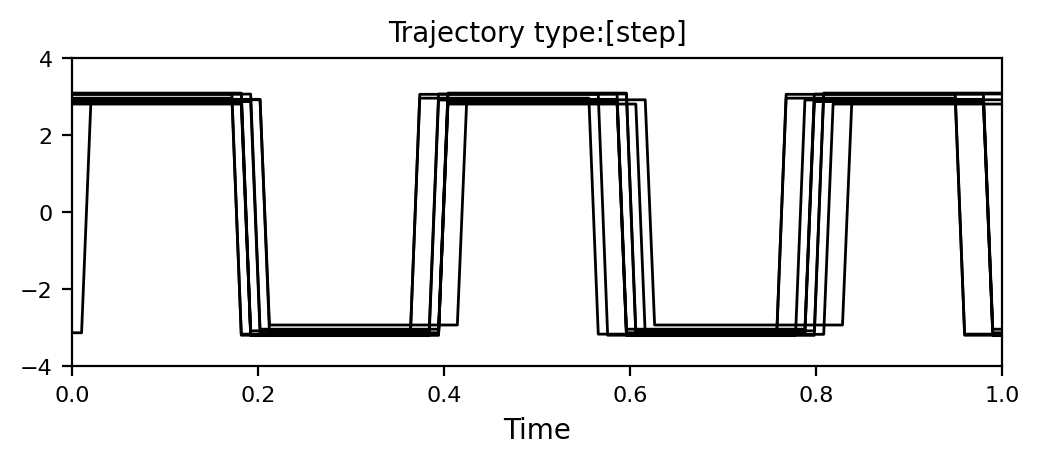

x_0:[10x1x100]


In [5]:
times,x_0 = get_1d_training_data(
    traj_type = 'step', # step / gp
    n_traj    = 10,
    L         = 100,
    device    = device,
    seed      = 1,
    plot_data = True,
    verbose   = True
    )

### Helper function to evaluate

In [6]:
def plot_ddpm_1d_result(x_0,step_list_to_append,x_t_list,ylim=(-4,+4)):
    # Plot a seqeunce of ancestral sampling procedure
    plt.figure(figsize=(15,2)); plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
    x_0_np = x_0.detach().cpu().numpy() # [n_data x C x L]
    n_data = x_0_np.shape[0]
    for i_idx,t in enumerate(step_list_to_append):
        plt.subplot(1,len(step_list_to_append),i_idx+1)
        x_t = x_t_list[t] # [n_sample x C x L]
        x_t_np = x_t.detach().cpu().numpy() # [n_sample x C x L]
        for i_idx in range(n_data): # GT
            plt.plot(times.flatten(),x_0_np[i_idx,0,:],ls='-',color='b',lw=1)
        for i_idx in range(n_sample): # sampled
            plt.plot(times.flatten(),x_t_np[i_idx,0,:],ls='-',color='k',lw=1/4)
        plt.xlim([0.0,1.0]); plt.ylim(ylim)
        plt.xlabel('Time',fontsize=8); plt.title('Step:[%d]'%(t),fontsize=8)
    plt.tight_layout(); plt.show()
    # Plot generated data
    plt.figure(figsize=(6,3))
    x_t_np = x_t_list[0].detach().cpu().numpy() # [n_sample x C x L]
    for i_idx in range(n_data): # GT
        plt.plot(times.flatten(),x_0_np[i_idx,0,:],ls='-',color='b',lw=1)
    for i_idx in range(n_sample): # sampled
        plt.plot(times.flatten(),x_t_np[i_idx,0,:],ls='-',color='k',lw=1/4)
    plt.xlim([0.0,1.0]); plt.ylim(ylim)
    plt.xlabel('Time',fontsize=8)
    plt.title('Training trajectories (blue) and Generated trajectories (black)',fontsize=10)
    plt.tight_layout(); plt.show()
print ("Ready.")

Ready.


### Train

it:[      0][0.0]% loss:[4.9153]


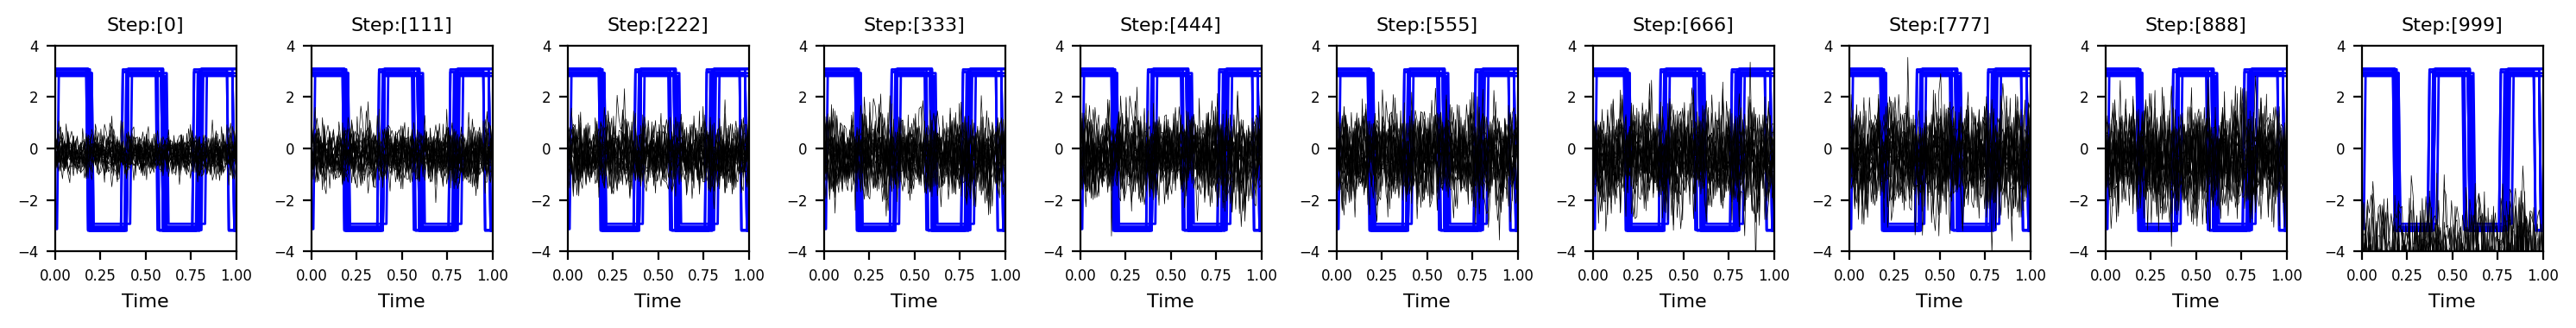

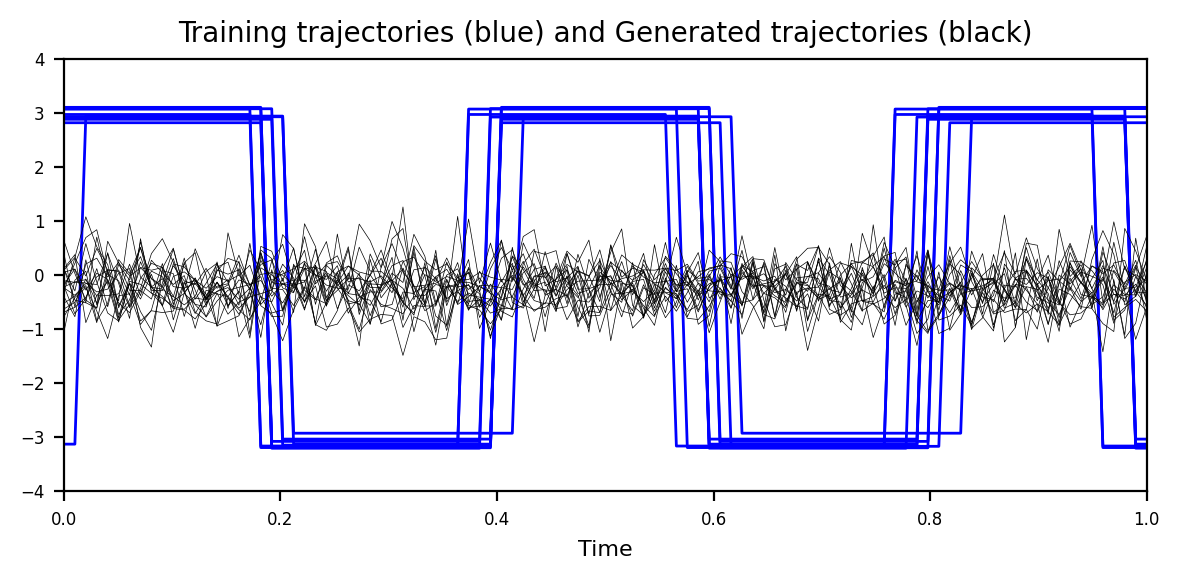

it:[   1000][10.0]% loss:[0.0501]


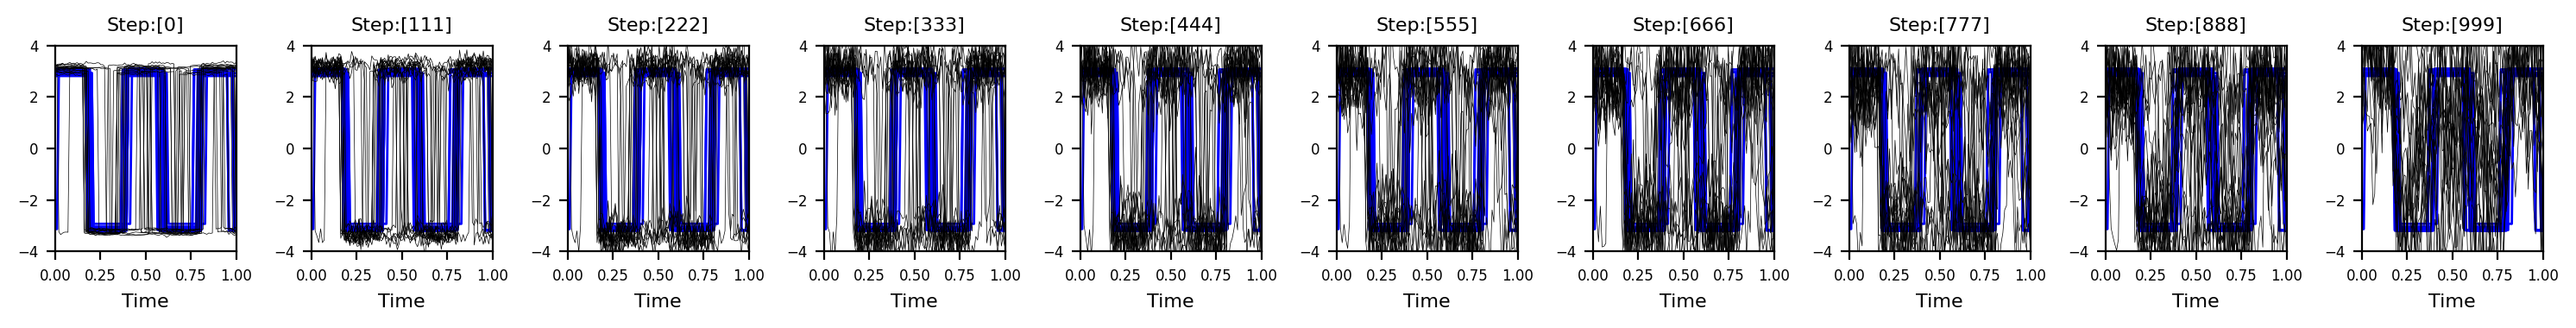

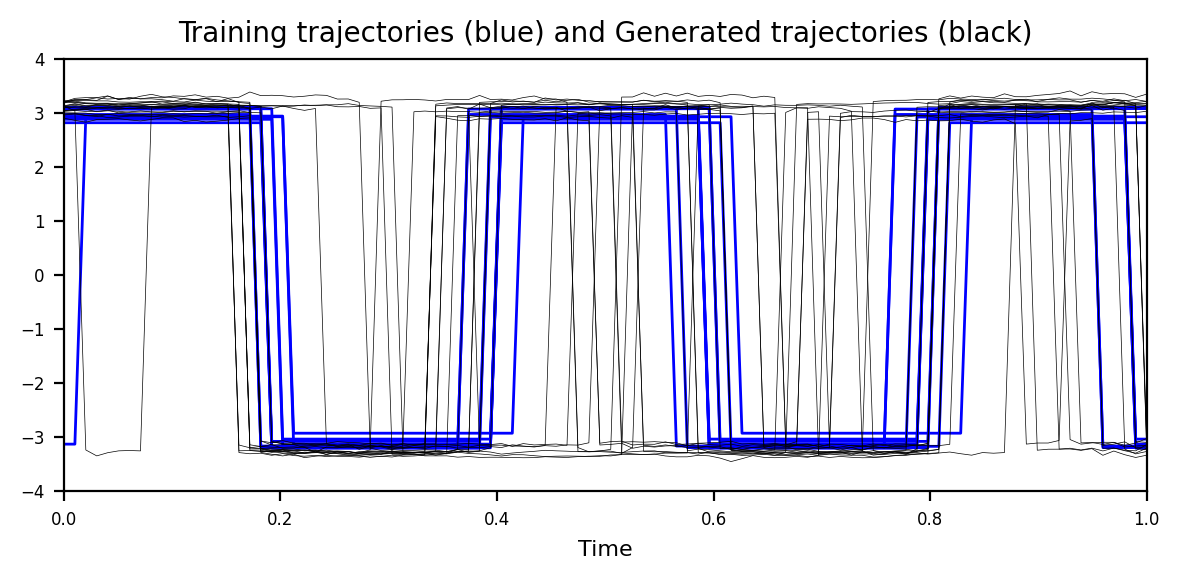

it:[   2000][20.0]% loss:[0.0272]


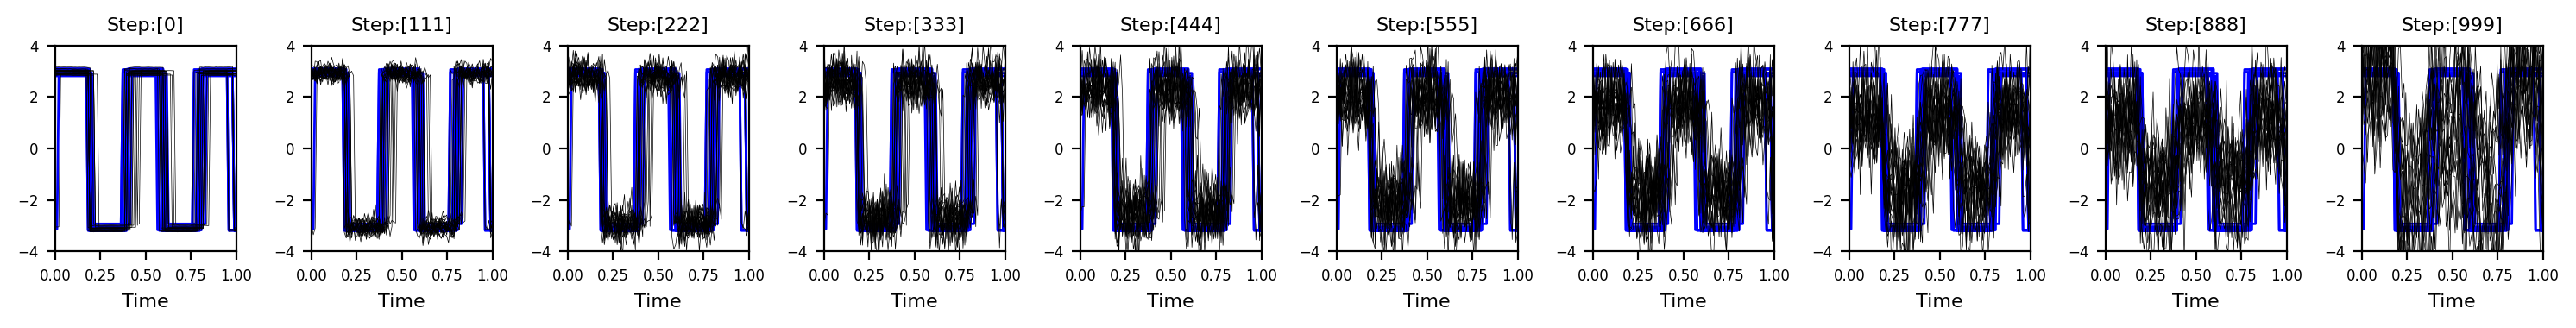

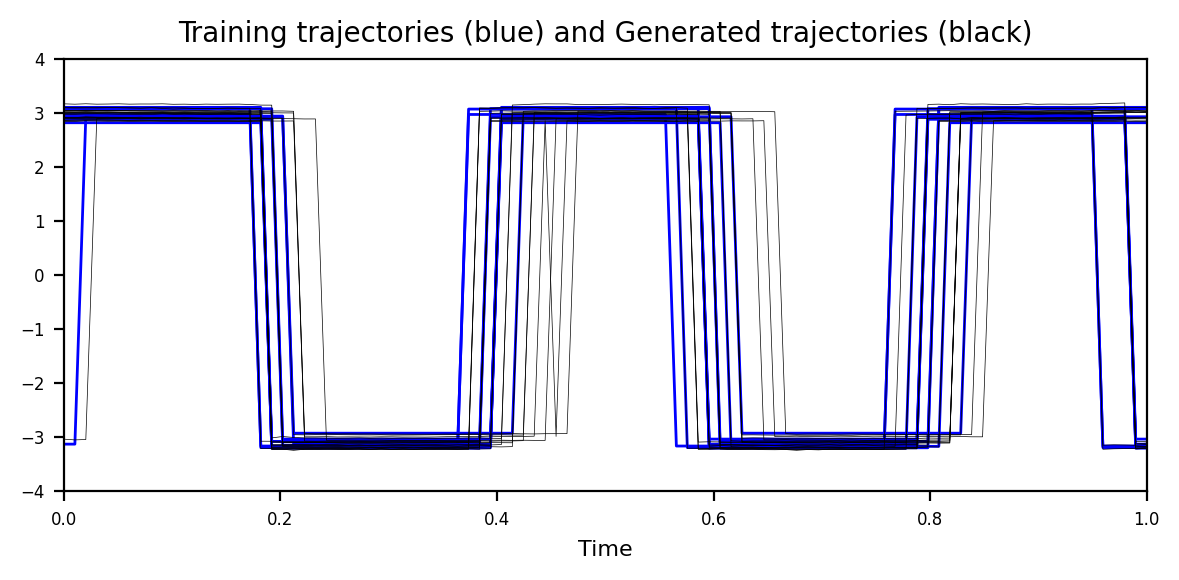

it:[   3000][30.0]% loss:[0.0202]


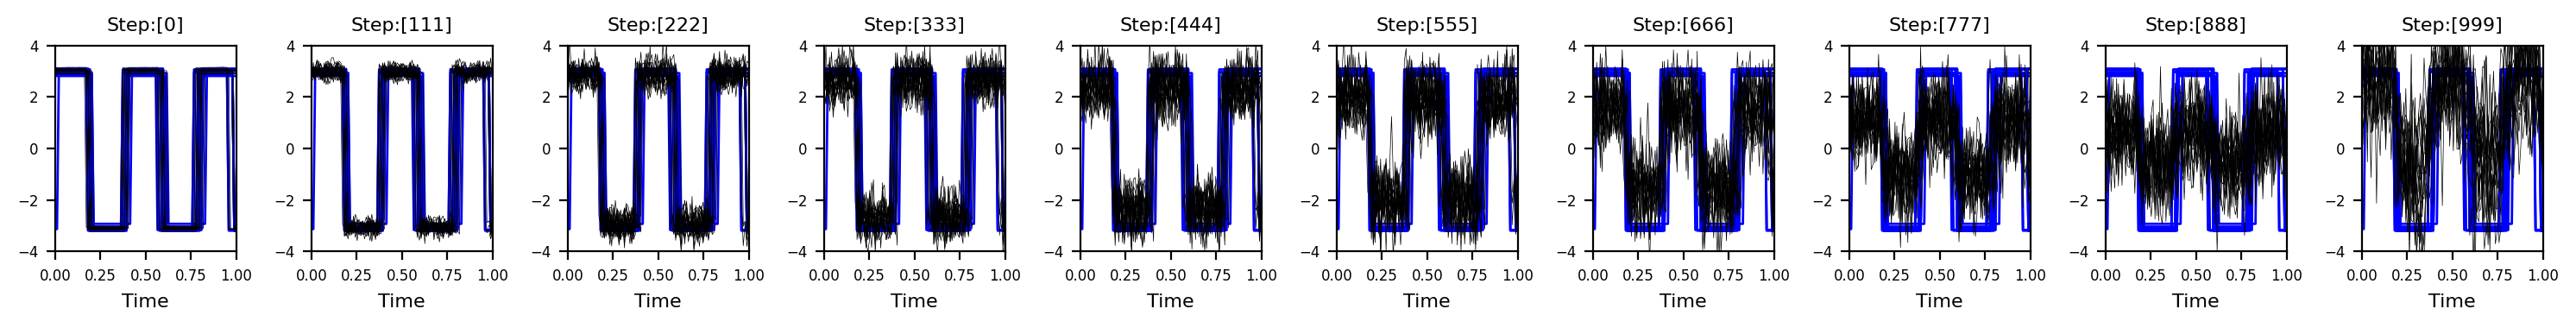

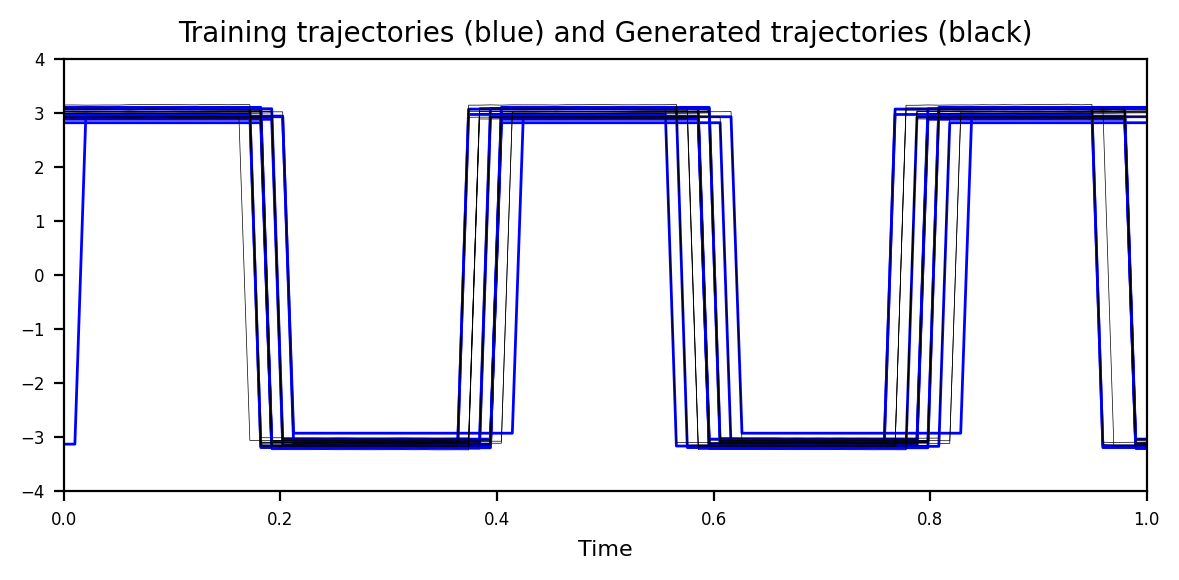

it:[   4000][40.0]% loss:[0.0202]


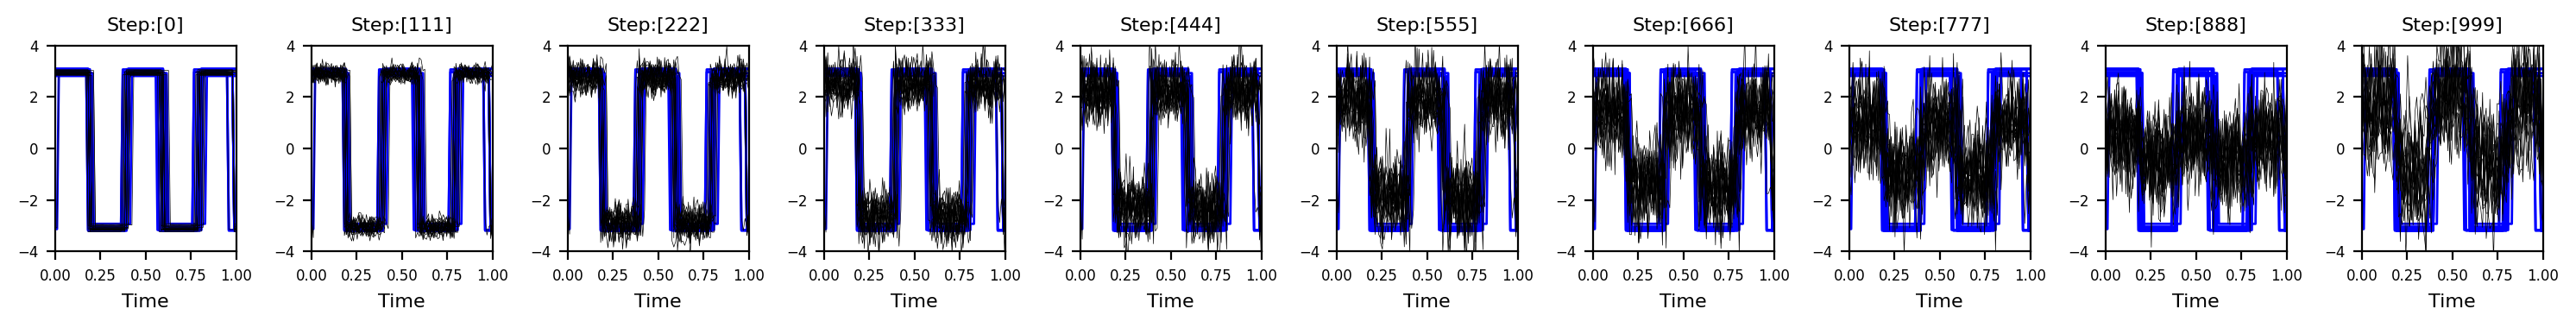

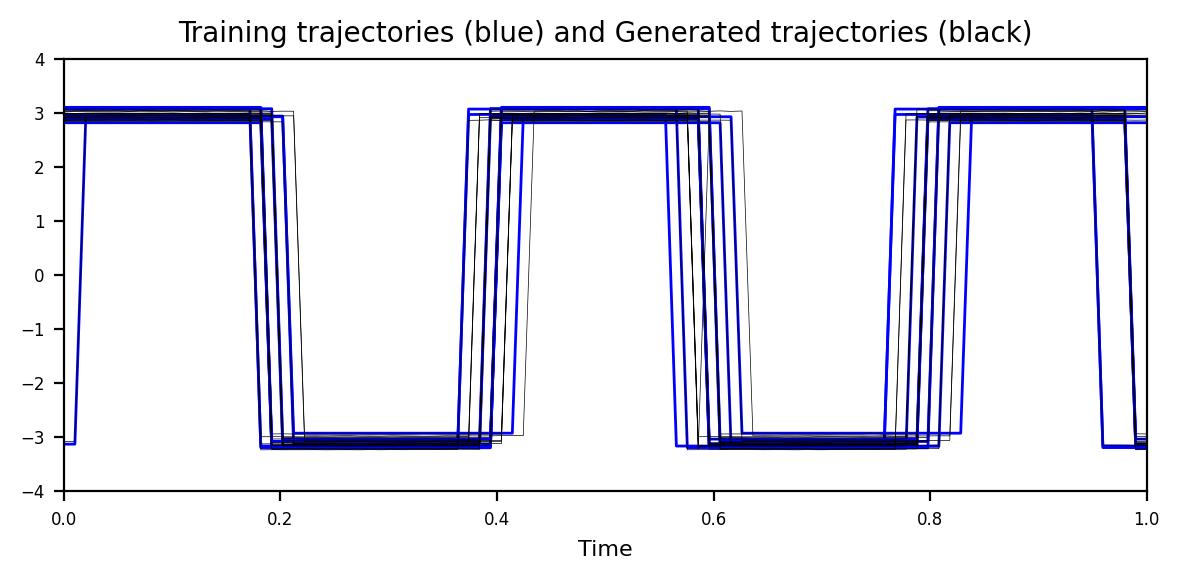

it:[   5000][50.0]% loss:[0.0162]


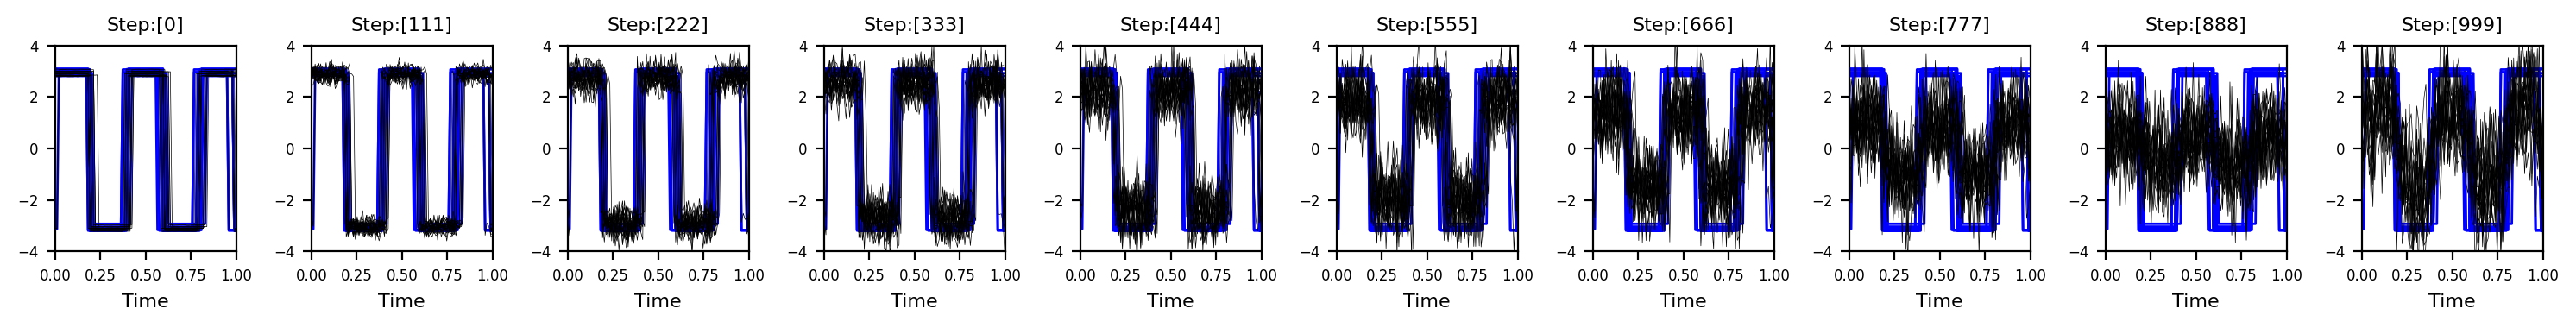

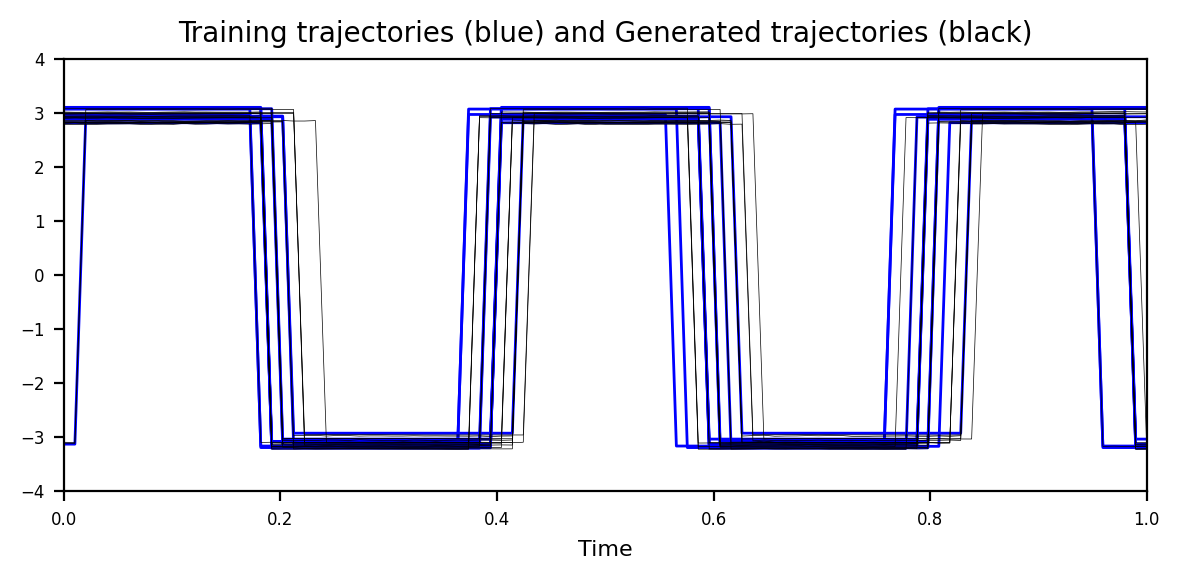

it:[   6000][60.0]% loss:[0.0174]


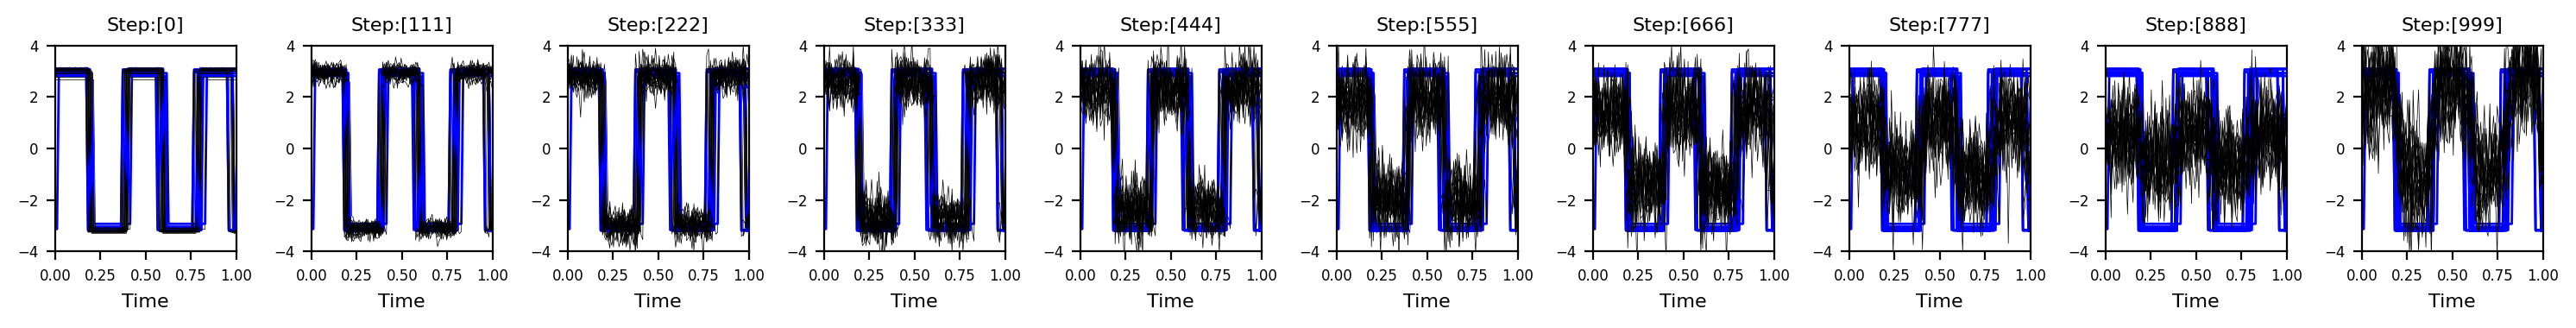

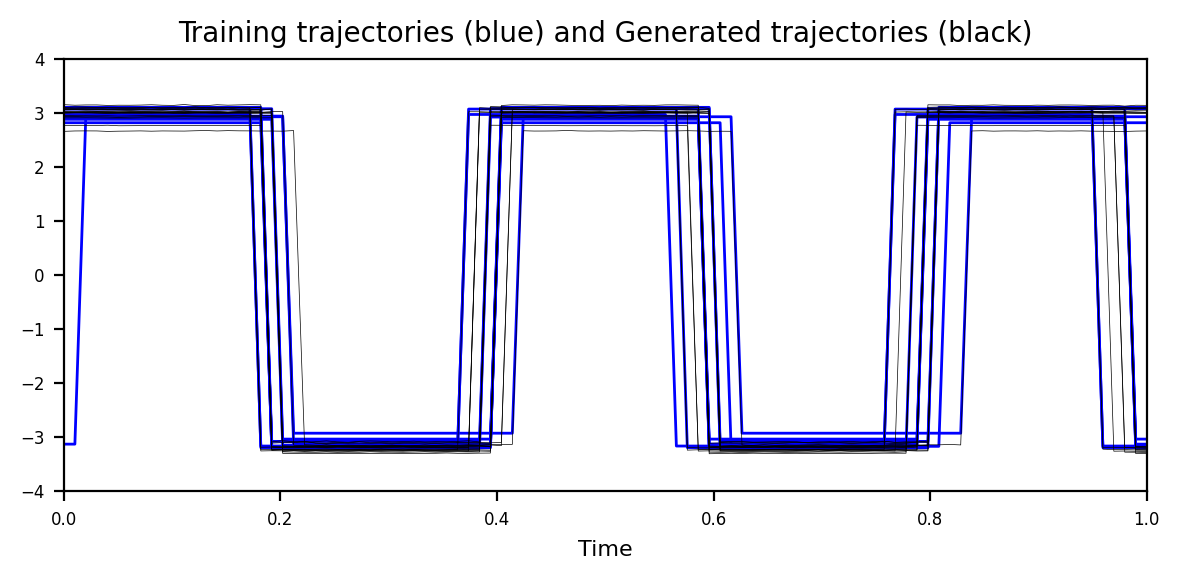

it:[   7000][70.0]% loss:[0.0141]


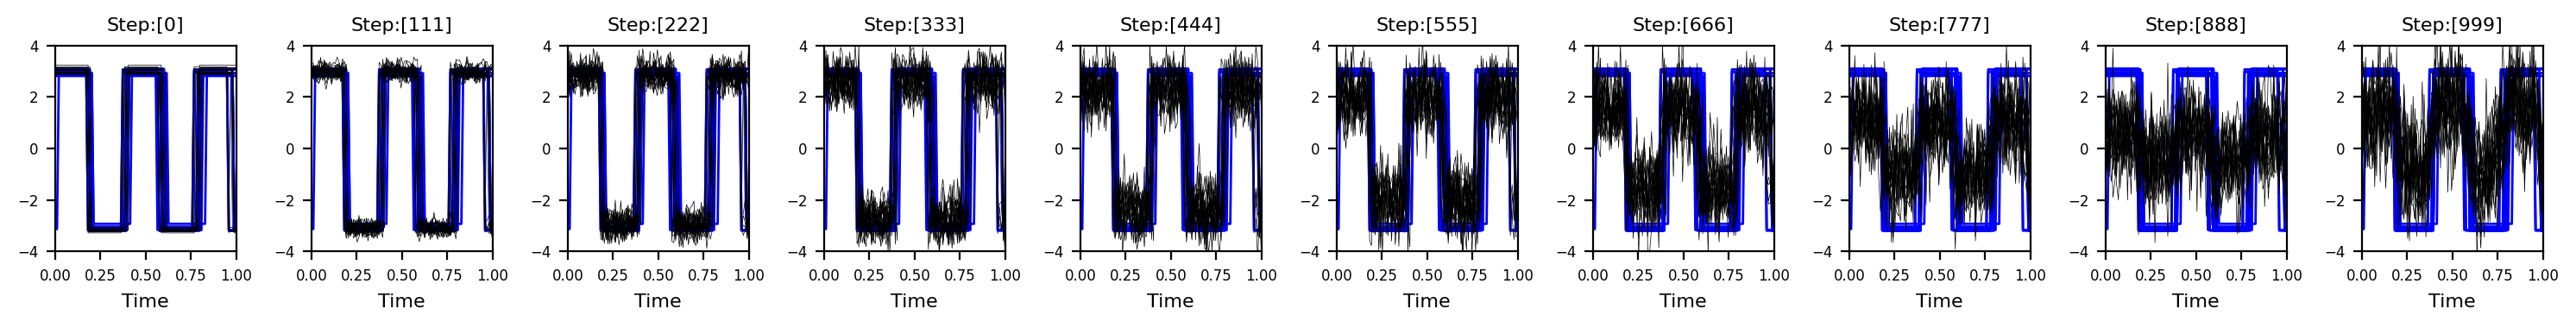

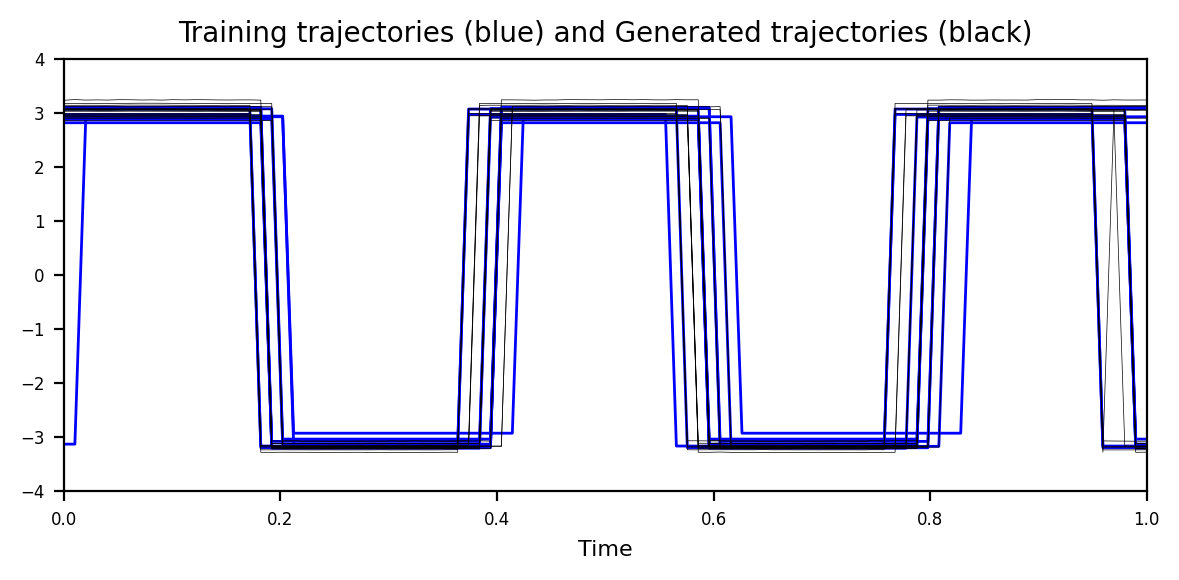

it:[   8000][80.0]% loss:[0.0167]


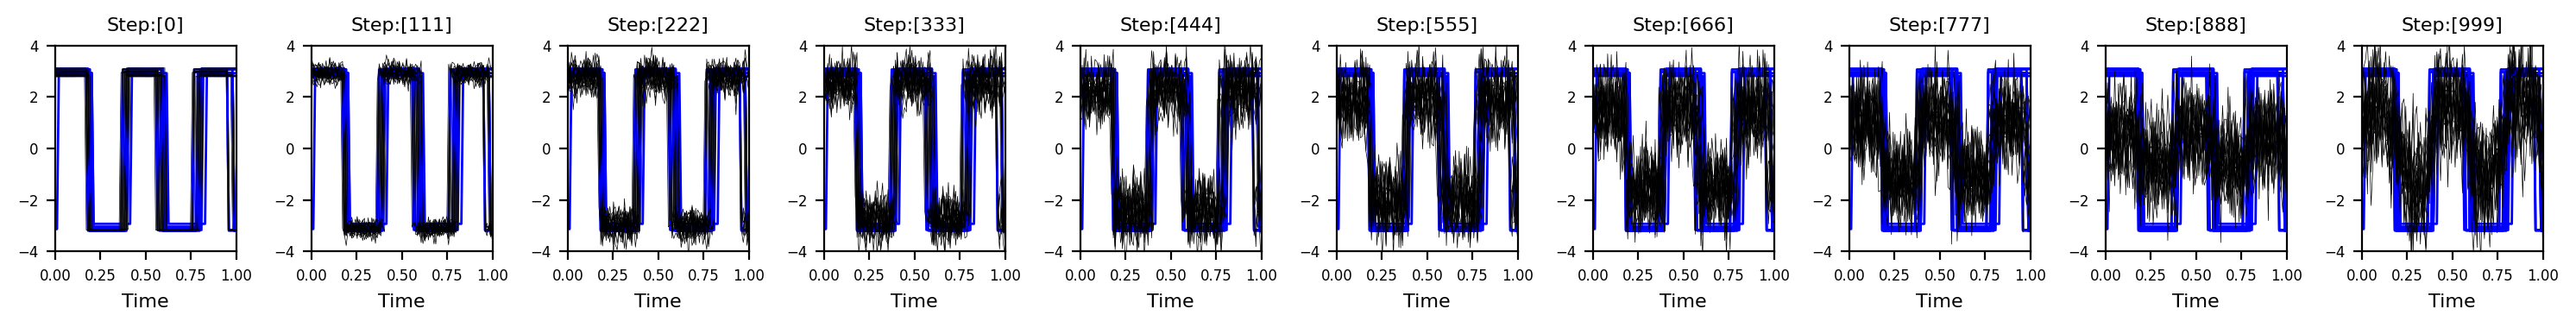

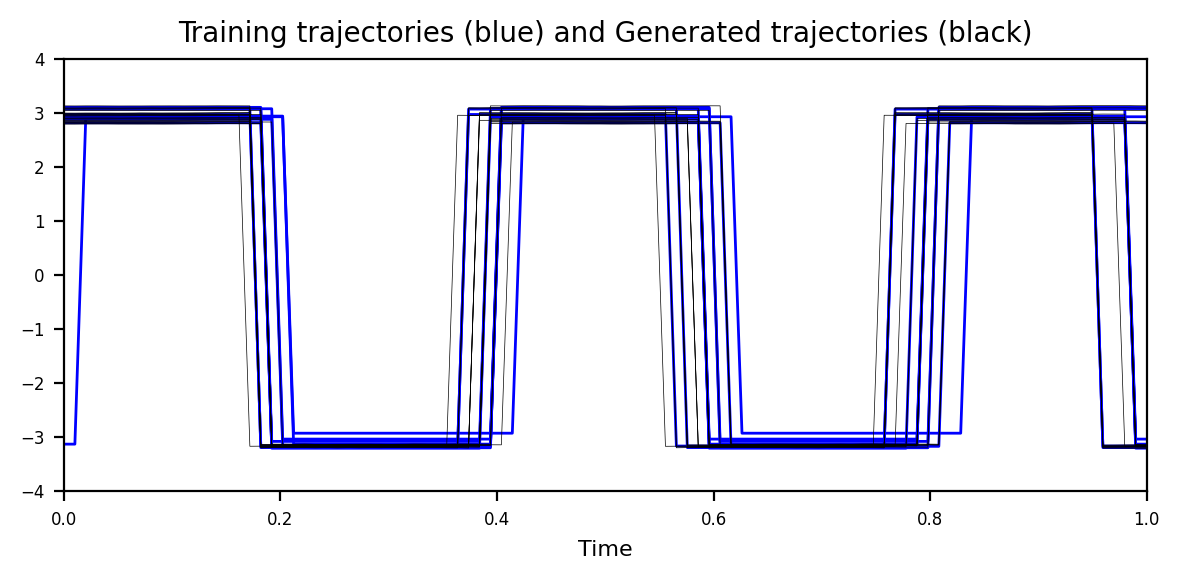

it:[   9000][90.0]% loss:[0.0162]


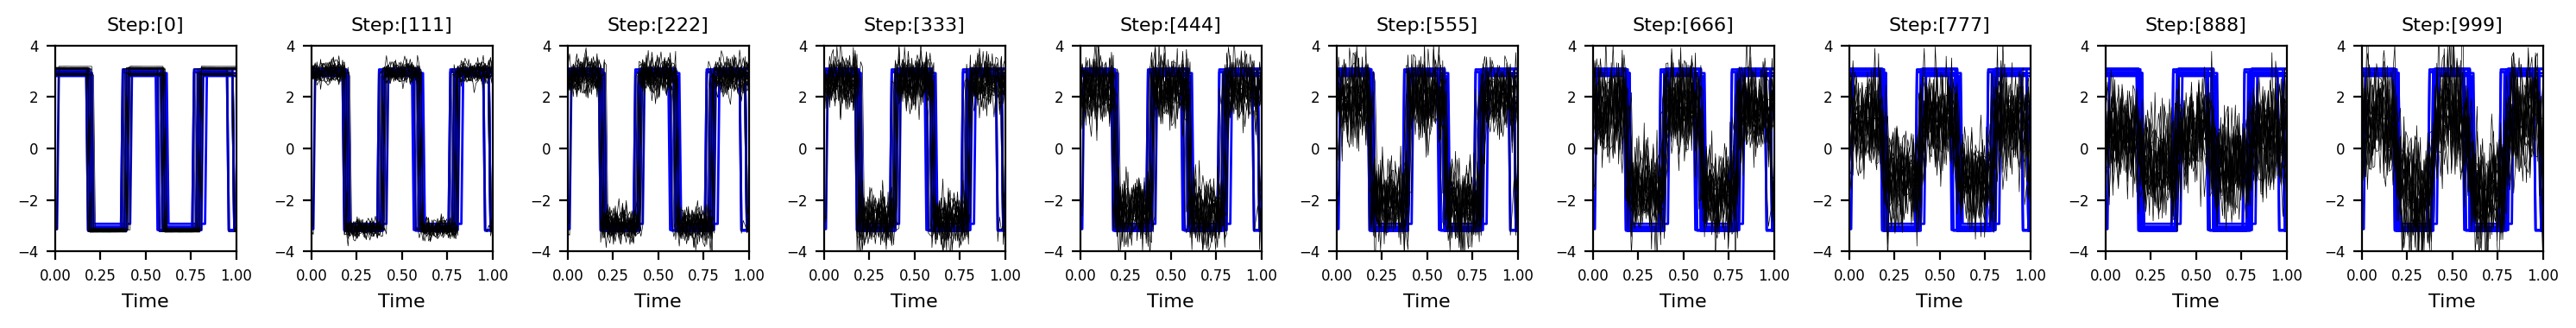

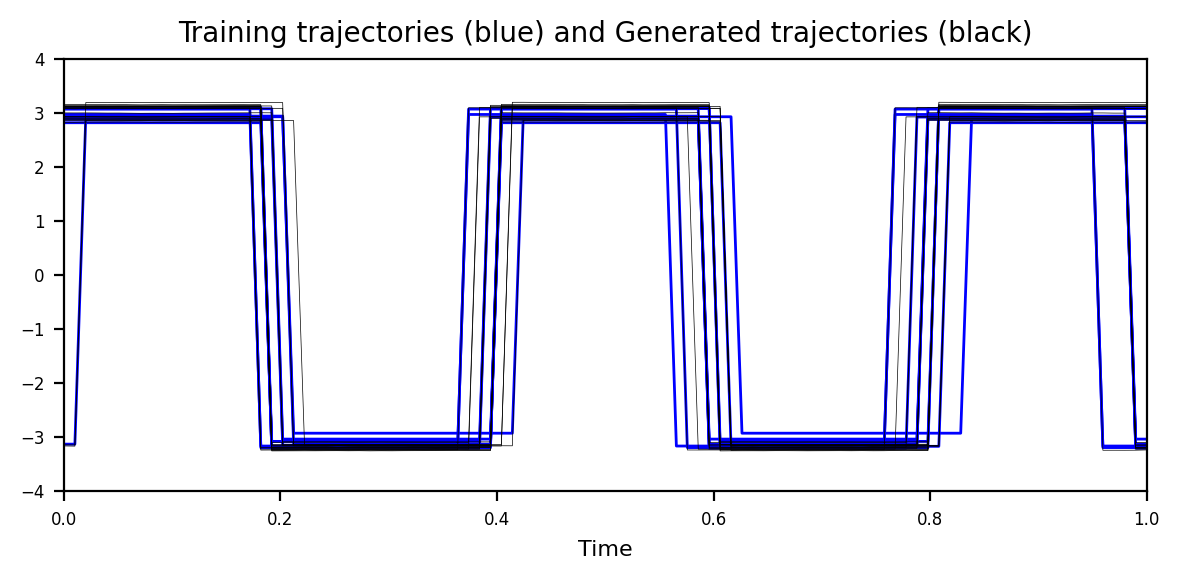

it:[   9999][100.0]% loss:[0.0120]


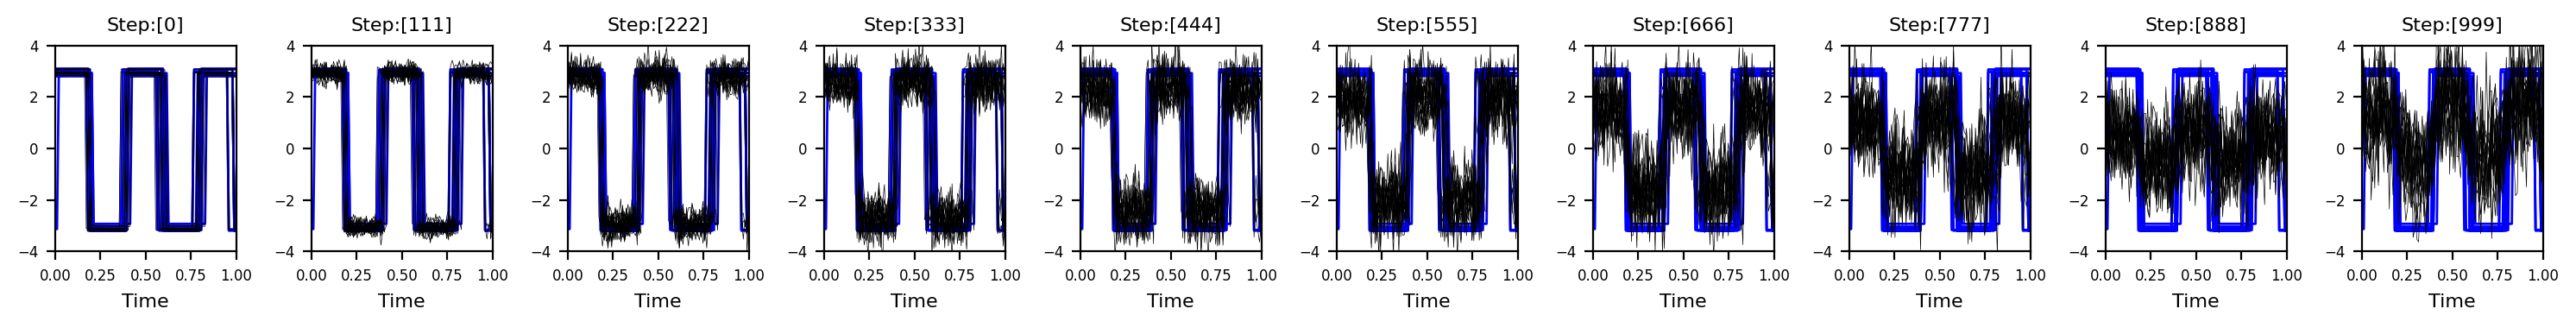

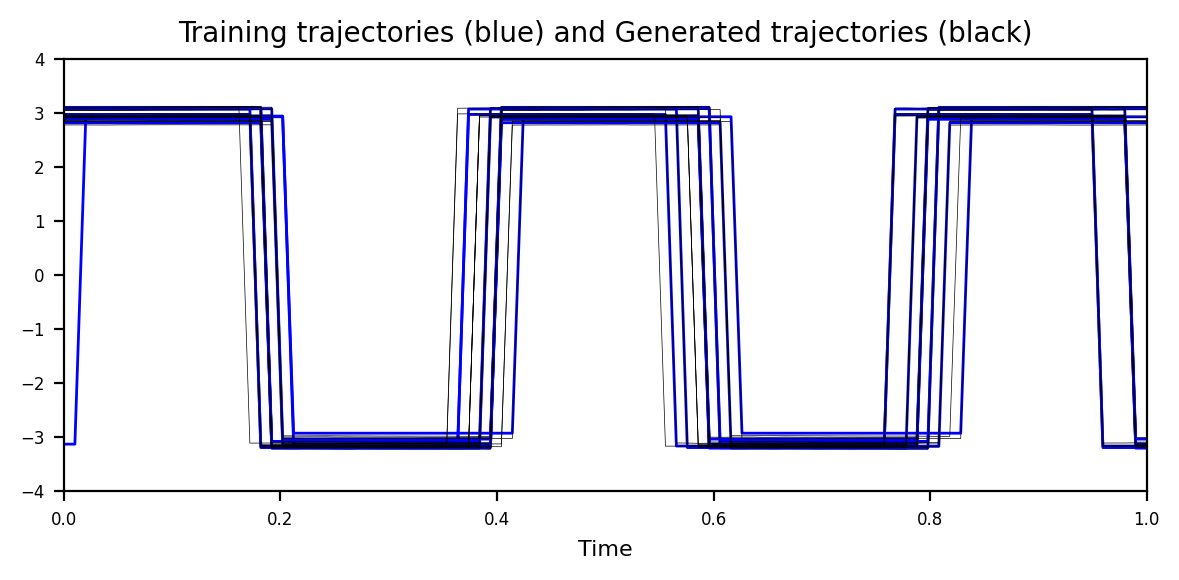

Done.


In [7]:
# Config
max_iter    = int(1e4)
batch_size  = 128
print_every = 1e3
eval_every  = 1e3

# Loop
model.train()
optm = th.optim.AdamW(params=model.parameters(),lr=1e-4,weight_decay=0.0)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm,gamma=0.99998)
for it in range(max_iter):
    
    # Zero gradient
    optm.zero_grad()
    
    # Get batch
    idx = np.random.choice(x_0.shape[0],batch_size)
    x_0_batch = x_0[idx,:,:] # [B x C x L]
    
    # Sample time steps
    step_batch = th.randint(0, dc['T'],(batch_size,),device=device).long() # [B]
    
    # Forward diffusion sampling
    x_t_batch,noise = forward_sample(x_0_batch,step_batch,dc) # [B x C x L]

    # Noise prediction
    noise_pred,_ = model(x_t_batch,step_batch) # [B x C x L]
    
    # Compute error
    loss = F.mse_loss(noise,noise_pred)
    
    # Update
    loss.backward()
    optm.step()
    schd.step()
    
    # Print
    if (it%print_every) == 0 or it == (max_iter-1):
        print ("it:[%7d][%.1f]%% loss:[%.4f]"%(it,100*it/max_iter,loss.item()))
    
    # Evaluate
    if (it%eval_every) == 0 or it == (max_iter-1):
        n_sample = 20
        step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
        x_t_list = eval_ddpm_1d(model,dc,n_sample,x_0,step_list_to_append,device)
        plot_ddpm_1d_result(x_0,step_list_to_append,x_t_list,ylim=(-4,+4))

print ("Done.")